# iNat AWS Export RFM Analysis

working with data from s3://inaturalist-open-data/metadata/inaturalist-open-data-latest.tar.gz

In [37]:
from datetime import datetime
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pyarrow
import seaborn as sns

In [7]:
aws_ods_dir = Path("/data-ssd/alex/datasets/inat-open-data/inaturalist-open-data-20240927/")

In [10]:
obs = pl.read_csv(
    aws_ods_dir / "observations.csv",
    separator="\t",
    try_parse_dates=True,
)

In [11]:
obs.select(
    pl.col("observed_on")
).max()

observed_on
date
2024-09-27


In [12]:
anchor_date = datetime(2024, 9, 27)

In [13]:
obs = obs.with_columns(
    (anchor_date - pl.col("observed_on")).alias("date_diff")
)

In [14]:
obs.sample(3)

observation_uuid,observer_id,latitude,longitude,positional_accuracy,taxon_id,quality_grade,observed_on,date_diff
str,i64,f64,f64,i64,i64,str,date,duration[μs]
"""39f72074-7c44-46fc-8ec1-b693cd…",1765983,-0.417288,-80.396907,96,277083,"""needs_id""",2015-07-20,3357d
"""61a3e2cf-33a6-4e6b-b7ea-080ea1…",2539505,38.215516,-83.003236,14149,60773,"""needs_id""",2022-06-16,834d
"""5df75c89-bc07-4a01-9d84-54998f…",144923,38.841782,-76.51218,1115,1363161,"""needs_id""",2020-08-07,1512d


In [24]:
obs = obs.drop_nulls(subset="taxon_id")

In [86]:
obs_agg = (obs
    .group_by("observer_id")
    .agg([
        pl.col("date_diff").min().alias("recency"),
        pl.len().alias("obs count"),
        pl.col("taxon_id").unique().len().alias("taxa count"),
    ])
)

In [87]:
# convert to pandas for viz?
obs_agg = obs_agg.to_pandas()
obs_agg.recency = obs_agg.recency.dt.days

In [88]:
obs_agg = obs_agg.set_index("observer_id")

In [89]:
obs_agg.describe()

,recency,obs count,taxa count
count,872856.000000,872922.000000,872922.000000
mean,677.244466,184.330585,82.785576
std,732.998280,1655.295230,317.334884
min,0.000000,1.000000,1.000000
25%,74.000000,10.000000,9.000000
50%,443.000000,21.000000,19.000000
75%,1114.000000,56.000000,48.000000
max,22623.000000,319116.000000,29516.000000


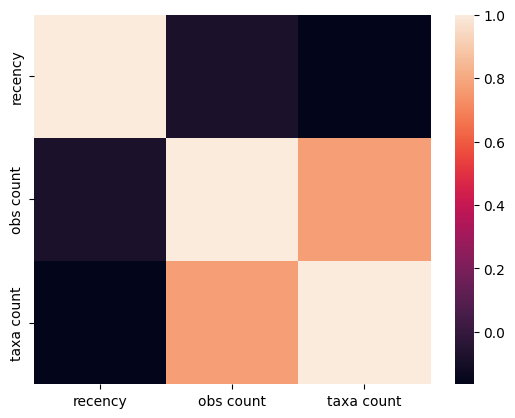

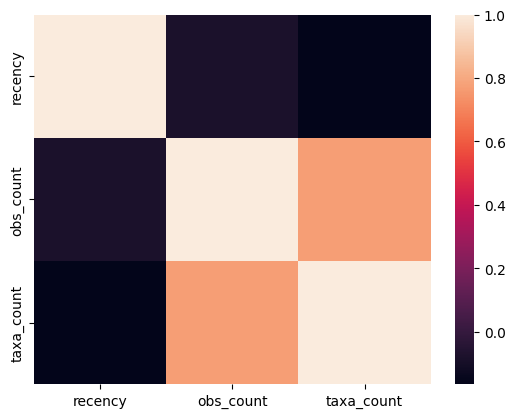

In [85]:
obs_agg_norm = obs_agg / obs_agg.max()
corr = obs_agg_norm.corr()
sns.heatmap(
    corr, 
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values
)
plt.show()

In [73]:
obs_agg

,recency,frequency,taxa_ct
observer_id,,,
306991,63.0,1718,638
2130847,1805.0,11,11
6777099,515.0,106,86
7222507,74.0,70,69
7477464,360.0,14,13
...,...,...,...
2922549,1402.0,14,13
5757548,849.0,13,13
2055331,13.0,295,267
